# 1. 预处理

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from pathlib import Path
from typing import Optional, List
from torchvision.transforms.v2.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from torchvision.utils import flow_to_image
import pickle
from torchcodec.decoders import VideoDecoder
import cv2
import ot
import tempfile
import open_clip
import imageio
from IPython.display import Video, display

In [1]:
import os
import json
import pickle
import random
import matplotlib.pyplot as plt
from evaluate import VideoClip, get_saliency_score, get_embeddings_score, get_motion_score


# ========== 工具函数部分 ==========

def load_video_ids(json_path, limit=None):
    """读取 jsonl 文件中的 video_id 列表"""
    ids = []
    with open(json_path, "r") as f:
        for line in f:
            ids.append(json.loads(line)["video_id"])
    return ids[:limit] if limit else ids


def load_clips(video_id):
    """加载某个视频的 clips.pkl"""
    clips_path = f"data/videos/mashup/{video_id}/clips.pkl"
    if not os.path.exists(clips_path):
        # print(f"[Skip] clips.pkl not found: {video_id}")
        return None
    with open(clips_path, "rb") as f:
        return pickle.load(f)


def compute_pair_scores(c1, c2):
    """对两个 clip （或任意片段对象）计算三个得分"""
    return (
        get_saliency_score(c1, c2),
        get_embeddings_score(c1, c2),
        get_motion_score(c1, c2),
    )


def plot_distribution(values, title):
    """画一个直方图"""
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=50, range=(0,1), alpha=0.75)
    plt.title(title)
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


def print_overall_stats(name, values):
    """打印平均值"""
    print(f"{name} Average Score: {sum(values)/len(values):.4f}")


# 2. 测试 human-made videos

=== Human-made Video Score Distributions ===
Composition Average Score: 0.7853
Semantic Average Score: 0.9452
Motion Average Score: 0.6349


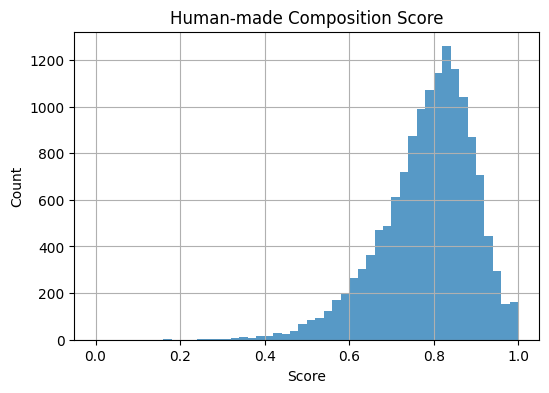

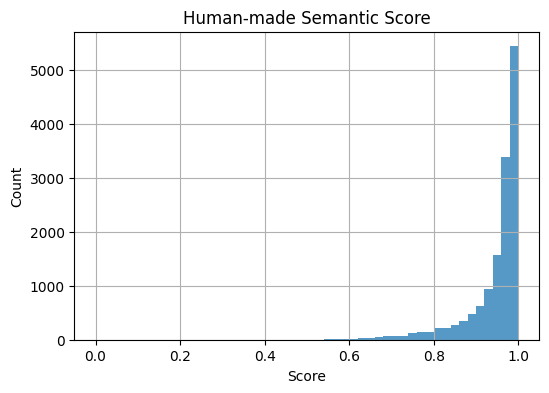

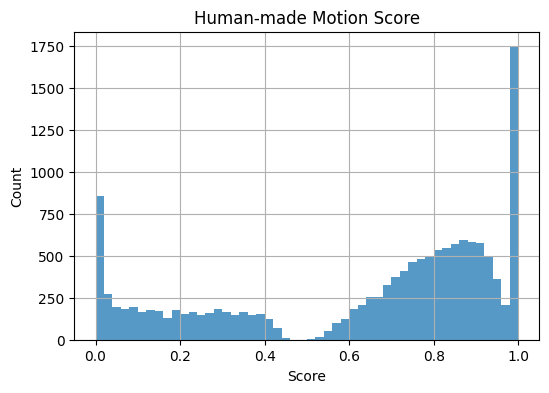

In [2]:
# ========== Human-made 视频实验 ==========

mashup_json_path = "data/json/mashup.json"
video_ids = load_video_ids(mashup_json_path)

all_saliency_scores = []
all_embeddings_scores = []
all_motion_scores = []

for vid in video_ids:
    clips = load_clips(vid)
    if clips is None or len(clips) < 2:
        continue

    for k in range(len(clips) - 1):
        try:
            s_sal, s_emb, s_mot = compute_pair_scores(clips[k], clips[k+1])
            all_saliency_scores.append(s_sal)
            all_embeddings_scores.append(s_emb)
            all_motion_scores.append(s_mot)
        except Exception as e:
            print(f"[Error] scoring failed for {vid}: {e}")


print("=== Human-made Video Score Distributions ===")
print_overall_stats("Composition", all_saliency_scores)
print_overall_stats("Semantic", all_embeddings_scores)
print_overall_stats("Motion", all_motion_scores)

plot_distribution(all_saliency_scores, "Human-made Composition Score")
plot_distribution(all_embeddings_scores, "Human-made Semantic Score")
plot_distribution(all_motion_scores, "Human-made Motion Score")


# 3. 测试随机拼接

=== Random Clip Pair Distributions ===
Random Composition Average Score: 0.7716
Random Semantic Average Score: 0.6491
Random Motion Average Score: 0.5438


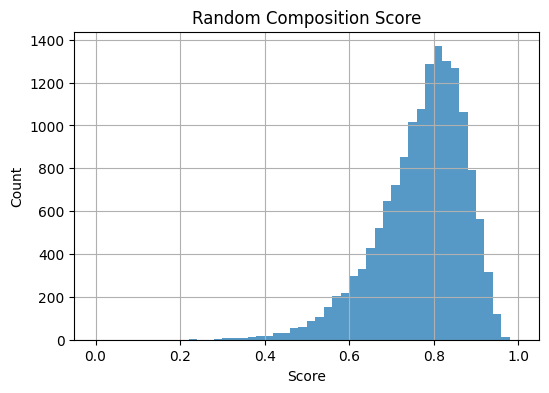

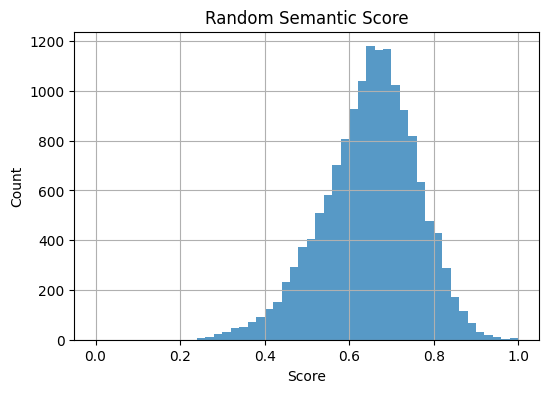

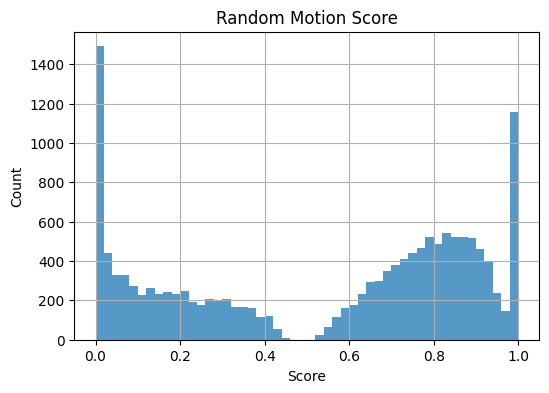

In [3]:
# ========== Random 拼接实验 ==========

N = 15000   # 你可以修改随机次数
random_sal = []
random_emb = []
random_mot = []

# 预加载所有 clips，避免重复读取
vid2clips = {}
for vid in video_ids:
    c = load_clips(vid)
    if c is not None and len(c) > 0:
        vid2clips[vid] = c

valid_video_ids = list(vid2clips.keys())

for _ in range(N):
    vid1, vid2 = random.sample(valid_video_ids, 2)
    clips1 = vid2clips[vid1]
    clips2 = vid2clips[vid2]

    c1 = random.choice(clips1)
    c2 = random.choice(clips2)

    try:
        s_sal, s_emb, s_mot = compute_pair_scores(c1, c2)
        random_sal.append(s_sal)
        random_emb.append(s_emb)
        random_mot.append(s_mot)
    except Exception as e:
        print(f"[Error] random scoring failed: {e}")
        continue

print("=== Random Clip Pair Distributions ===")
print_overall_stats("Random Composition", random_sal)
print_overall_stats("Random Semantic", random_emb)
print_overall_stats("Random Motion", random_mot)

plot_distribution(random_sal, "Random Composition Score")
plot_distribution(random_emb, "Random Semantic Score")
plot_distribution(random_mot, "Random Motion Score")
